# Libraries

In [54]:
import pandas as pd
from nltk.corpus import wordnet
import nltk
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import numpy as np
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

# Data Preparation

In [55]:
# Import data
df = pd.read_csv('/Users/khalil/Desktop/NLP/Reviews And Ratings.csv')
df

,Unnamed: 0,Rating,Lang,Type,Country,Date,Helpful,translated
0,72,5,it,Verified,Italy,11/1/2020,43.0,What to say? My daughter LOVES him and I with ...
1,85,5,it,Not Verified,Italy,9/10/2019,36.0,"I decided to test this plush to my grandson, j..."
2,107,5,it,Verified,Italy,8/12/2019,2.0,"An unusual pet, this otter is beautiful! Cute ..."
3,109,4,it,Verified,Italy,4/2/2021,1.0,"Beautiful, soft and very relaxing. It comes wi..."
4,113,4,it,Verified,Italy,21/02/2020,2.0,"Plush tender, my 16-month-old loves it, sleeps..."
...,...,...,...,...,...,...,...,...
1530,1310,5,fr,Verified,France,18/12/2019,NaN,Great I recommend
1531,1311,5,fr,Verified,France,26/10/2020,NaN,odee gift
1532,1312,5,fr,Verified,France,27/01/2020,NaN,Gift noel bb
1533,1313,5,fr,Verified,France,23/12/2019,NaN,Super plush


In [56]:
df = df[df['Rating'] != 0]
#Creating Positive & Negative sentiments as POSITIVE and NEGATIVE according to rating
df['sentiment'] = df['Rating'].apply(lambda rating : 1 if rating >= 4 else 0)

In [57]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == 0]

In [58]:
dfNew = df[['translated','sentiment']]
dfNew.head()

,translated,sentiment
0,What to say? My daughter LOVES him and I with ...,1
1,"I decided to test this plush to my grandson, j...",1
2,"An unusual pet, this otter is beautiful! Cute ...",1
3,"Beautiful, soft and very relaxing. It comes wi...",1
4,"Plush tender, my 16-month-old loves it, sleeps...",1


# Preprocessing and data cleaning 

In [59]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# return the wordnet object value corresponding to the POS tag
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
dfNew["review_clean"] = dfNew["translated"].apply(lambda x: clean_text(x))

/var/folders/0g/4ffgvpkj3gj_tfnmlbcwlll40000gn/T/ipykernel_9749/2440289575.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
dfNew

,translated,sentiment,review_clean
0,What to say? My daughter LOVES him and I with ...,1,say daughter love soft zero visible seam tende...
1,"I decided to test this plush to my grandson, j...",1,decided test plush grandson three year old soo...
2,"An unusual pet, this otter is beautiful! Cute ...",1,unusual pet otter beautiful cute melody light ...
3,"Beautiful, soft and very relaxing. It comes wi...",1,beautiful soft relaxing come behind back key s...
4,"Plush tender, my 16-month-old loves it, sleeps...",1,plush tender love sleep hug cuddle even wake p...
...,...,...,...
1530,Great I recommend,1,great recommend
1531,odee gift,1,odee gift
1532,Gift noel bb,1,gift noel bb
1533,Super plush,1,super plush


# EDA

In order to have a better understanding of our data, let's explore it a little:

In [61]:
dfNew["sentiment"].value_counts(normalize = True)

1    0.848208
0    0.151792
Name: sentiment, dtype: float64

In [62]:


#Distribution of sentiments amongst samples.
df['sentimentt'] = df['sentiment'].replace({0 : 'NEGATIVE'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'POSITIVE'})
fig = px.histogram(df, x="sentimentt")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()


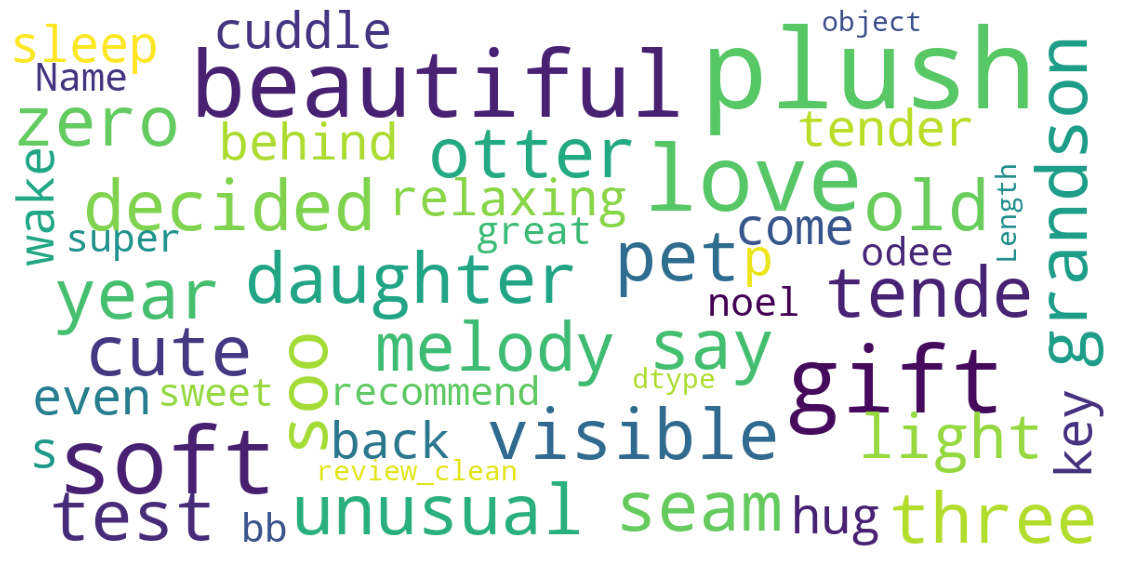

In [63]:
# wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(dfNew["review_clean"])

# Building a Sentiment Classifier (SVM)

In [64]:
# Split the data
train, test = train_test_split(dfNew, test_size=0.2, random_state=1)
X_train = train['review_clean'].values
X_test = test['review_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [65]:
#  Build the model, Cross validation and Grid search 
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

vectorizer = CountVectorizer()

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8684129901960783

In [66]:
grid_svm.best_params_

{'svc__C': 0.01}

In [67]:
grid_svm.best_score_

0.8770806007648113

In [68]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [69]:
# Model evaluation
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8684129901960783,
 'f1': 0.9186046511627908,
 'acc': 0.8631921824104235,
 'precision': 0.9115384615384615,
 'recall': 0.92578125}

In [70]:
# Roc curve plot
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [71]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

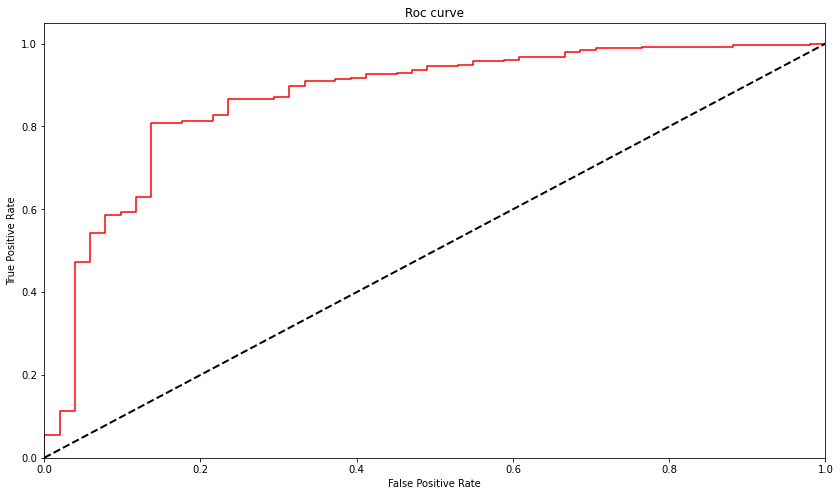

In [72]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()